In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import rbf_kernel, polynomial_kernel
from scipy.linalg import eigh
from sklearn.model_selection import train_test_split

# Function to load and impute data
def load_and_impute_data(file_path):
    data = pd.read_csv(file_path)
    labels = data['Label']
    features = data.drop(columns=['Label'])
    imputer = SimpleImputer(strategy='mean')
    features_imputed = pd.DataFrame(imputer.fit_transform(features), columns=features.columns)
    data_imputed = pd.concat([features_imputed, labels], axis=1)
    return data_imputed

# Function to normalize data
def normalize_data(features):
    non_zero_variance_features = features.loc[:, features.var() != 0]
    features_normalized = (non_zero_variance_features - non_zero_variance_features.mean()) / non_zero_variance_features.std()
    return features_normalized

# Function to compute covariance matrix
def compute_covariance_matrix(data):
    covariance_matrix = np.cov(data.T)
    return covariance_matrix

# Function to compute eigenvalues and eigenvectors
def compute_eigenvalues_eigenvectors(covariance_matrix):
    eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)
    return eigenvalues, eigenvectors

# Function to sort eigenvalues and eigenvectors
def sort_eigenvalues_eigenvectors(eigenvalues, eigenvectors):
    sorted_indices = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[sorted_indices]
    eigenvectors = eigenvectors[:, sorted_indices]
    return eigenvalues, eigenvectors

# Function to project data
def project_data(data, eigenvectors, num_components):
    return np.dot(data, eigenvectors[:, :num_components])

# PCA from scratch
def pca_from_scratch(file_path, variance_threshold=0.95):
    data = load_and_impute_data(file_path)
    labels = data['Label']
    features = data.drop(columns=['Label'])
    normalized_data = normalize_data(features)
    covariance_matrix = compute_covariance_matrix(normalized_data)
    eigenvalues, eigenvectors = compute_eigenvalues_eigenvectors(covariance_matrix)
    eigenvalues, eigenvectors = sort_eigenvalues_eigenvectors(eigenvalues, eigenvectors)
    total_variance = sum(eigenvalues)
    variance_explained = 0
    num_components = 0
    for eigenvalue in eigenvalues:
        variance_explained += eigenvalue
        num_components += 1
        if variance_explained / total_variance >= variance_threshold:
            break
    reduced_data = project_data(normalized_data, eigenvectors, num_components)
    return reduced_data, num_components, eigenvalues, eigenvectors

# KPCA with RBF Kernel
def kpca_rbf(X, gamma, n_components):
    K = rbf_kernel(X, gamma=gamma)
    N = K.shape[0]
    one_n = np.ones((N, N)) / N
    K_centered = K - one_n @ K - K @ one_n + one_n @ K @ one_n
    eigenvalues, eigenvectors = eigh(K_centered)
    idx = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    X_kpca = np.dot(K_centered, eigenvectors[:, :n_components])
    return X_kpca

# KPCA with Polynomial Kernel
def kpca_polynomial(X, degree, coef0, n_components):
    K = polynomial_kernel(X, degree=degree, coef0=coef0)
    N = K.shape[0]
    one_n = np.ones((N, N)) / N
    K_centered = K - one_n @ K - K @ one_n + one_n @ K @ one_n
    eigenvalues, eigenvectors = eigh(K_centered)
    idx = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    X_kpca = np.dot(K_centered, eigenvectors[:, :n_components])
    return X_kpca

# KPCA with Linear Kernel
def linear_kernel(X):
    return np.dot(X, X.T)

def kpca_linear(X, n_components):
    K = linear_kernel(X)
    N = K.shape[0]
    one_n = np.ones((N, N)) / N
    K_centered = K - one_n @ K - K @ one_n + one_n @ K @ one_n
    eigenvalues, eigenvectors = eigh(K_centered)
    idx = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    X_kpca = np.dot(K_centered, eigenvectors[:, :n_components])
    return X_kpca

# KPCA with Combined Kernels
def combined_kernel(X, kernel1, kernel2, alpha=0.5):
    return alpha * kernel1(X) + (1 - alpha) * kernel2(X)

def kpca_combined(X, kernel_func, n_components):
    K = kernel_func(X)
    N = K.shape[0]
    one_n = np.ones((N, N)) / N
    K_centered = K - one_n @ K - K @ one_n + one_n @ K @ one_n
    eigenvalues, eigenvectors = eigh(K_centered)
    idx = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    X_kpca = np.dot(K_centered, eigenvectors[:, :n_components])
    return X_kpca

# Define the combined kernel function
def combined_kernel_func(X):
    return combined_kernel(X, lambda X: rbf_kernel(X, gamma=0.1), lambda X: polynomial_kernel(X, degree=3, coef0=1), alpha=0.5)

# Function to calculate the distance between two points
def dis(x1, x2):
    return np.linalg.norm(x1 - x2)

# Function to perform classification
def myclassifier(train_data, train_labels, test_data):
    pred = []
    for testpoint in test_data:
        pred_dis = []
        for trainpoint in train_data:
            pred_dis.append(dis(testpoint, trainpoint))
        pred.append(train_labels.iloc[np.argmin(pred_dis)])
    return np.array(pred)

# Function to calculate accuracy
def calculate_accuracy(true_labels, predicted_labels):
    correct_predictions = sum(1 for true, predicted in zip(true_labels, predicted_labels) if true == predicted)
    accuracy = correct_predictions / len(true_labels)
    return accuracy

# Apply PCA and KPCA on the test dataset and evaluate performance
def evaluate_pca_kpca_performance(file_path):
    data = load_and_impute_data(file_path)
    labels = data['Label']
    features = data.drop(columns=['Label'])
    normalized_data = normalize_data(features)

    # Split the data into train and test sets
    train_data, test_data, train_labels, test_labels = train_test_split(normalized_data, labels, test_size=0.2, random_state=42)

    # Apply PCA on the training data using scikit-learn
    pca = PCA(n_components=0.95)
    train_data_pca = pca.fit_transform(train_data)
    test_data_pca = pca.transform(test_data)

    # Apply KPCA on the training data
    gamma = 0.1
    degree = 3
    coef0 = 1
    alpha = 0.5
    num_components = 10

    # KPCA with RBF Kernel
    train_data_kpca_rbf = kpca_rbf(train_data, gamma, num_components)
    test_data_kpca_rbf = kpca_rbf(test_data, gamma, num_components)

    # KPCA with Polynomial Kernel
    train_data_kpca_poly = kpca_polynomial(train_data, degree, coef0, num_components)
    test_data_kpca_poly = kpca_polynomial(test_data, degree, coef0, num_components)

    # KPCA with Linear Kernel
    train_data_kpca_linear = kpca_linear(train_data, num_components)
    test_data_kpca_linear = kpca_linear(test_data, num_components)

    # KPCA with Combined Kernels
    train_data_kpca_combined = kpca_combined(train_data, combined_kernel_func, num_components)
    test_data_kpca_combined = kpca_combined(test_data, combined_kernel_func, num_components)

    return test_labels, train_labels, train_data_pca, test_data_pca, train_data_kpca_rbf, test_data_kpca_rbf, train_data_kpca_poly, test_data_kpca_poly, train_data_kpca_linear, test_data_kpca_linear, train_data_kpca_combined, test_data_kpca_combined

In [103]:
# Evaluate the performance
file_path = 'Thyloid.csv'
test_labels, train_labels, train_data_pca, test_data_pca, train_data_kpca_rbf, test_data_kpca_rbf, train_data_kpca_poly, test_data_kpca_poly, train_data_kpca_linear, test_data_kpca_linear, train_data_kpca_combined, test_data_kpca_combined = evaluate_pca_kpca_performance(file_path)

# Perform classification using the minimum distance classifier
predictions_pca = myclassifier(train_data_pca, train_labels, test_data_pca)
predictions_kpca_rbf = myclassifier(train_data_kpca_rbf, train_labels, test_data_kpca_rbf)
predictions_kpca_poly = myclassifier(train_data_kpca_poly, train_labels, test_data_kpca_poly)
predictions_kpca_linear = myclassifier(train_data_kpca_linear, train_labels, test_data_kpca_linear)
predictions_kpca_combined = myclassifier(train_data_kpca_combined, train_labels, test_data_kpca_combined)

# Calculate accuracy
accuracy_pca = calculate_accuracy(test_labels, predictions_pca)
accuracy_kpca_rbf = calculate_accuracy(test_labels, predictions_kpca_rbf)
accuracy_kpca_poly = calculate_accuracy(test_labels, predictions_kpca_poly)
accuracy_kpca_linear = calculate_accuracy(test_labels, predictions_kpca_linear)
accuracy_kpca_combined = calculate_accuracy(test_labels, predictions_kpca_combined)

# Print the results
print(f'PCA Accuracy: {accuracy_pca}')
print(f'KPCA (RBF Kernel) Accuracy: {accuracy_kpca_rbf}')
print(f'KPCA (Polynomial Kernel) Accuracy: {accuracy_kpca_poly}')
print(f'KPCA (Linear Kernel) Accuracy: {accuracy_kpca_linear}')
print(f'KPCA (Combined Kernels) Accuracy: {accuracy_kpca_combined}')

PCA Accuracy: 0.4434782608695652
KPCA (RBF Kernel) Accuracy: 0.391304347826087
KPCA (Polynomial Kernel) Accuracy: 0.5826086956521739
KPCA (Linear Kernel) Accuracy: 0.45217391304347826
KPCA (Combined Kernels) Accuracy: 0.5652173913043478


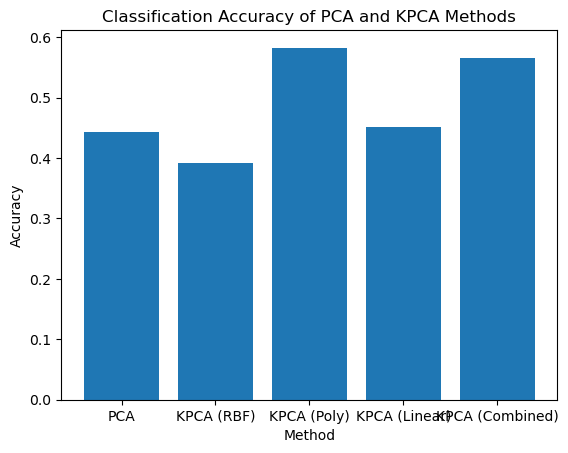

In [58]:
# Visualize the results
accuracies = [accuracy_pca, accuracy_kpca_rbf, accuracy_kpca_poly, accuracy_kpca_linear, accuracy_kpca_combined]
labels = ['PCA', 'KPCA (RBF)', 'KPCA (Poly)', 'KPCA (Linear)', 'KPCA (Combined)']
plt.bar(labels, accuracies)
plt.xlabel('Method')
plt.ylabel('Accuracy')
plt.title('Classification Accuracy of PCA and KPCA Methods')
plt.show()

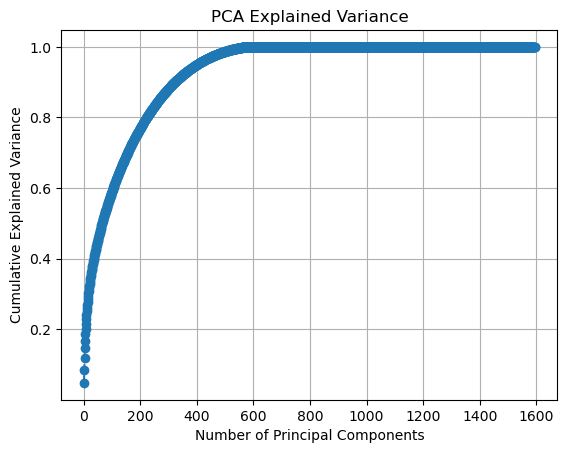

In [63]:
# Plot explained variance for PCA
_, _, pca_eigenvalues, _ = pca_from_scratch(file_path)
explained_variance_ratio = pca_eigenvalues / pca_eigenvalues.sum()
cumulative_variance = np.cumsum(explained_variance_ratio)

plt.figure()
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.grid()
plt.show()

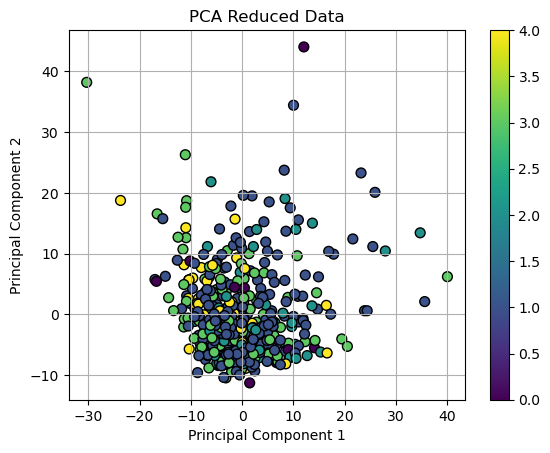

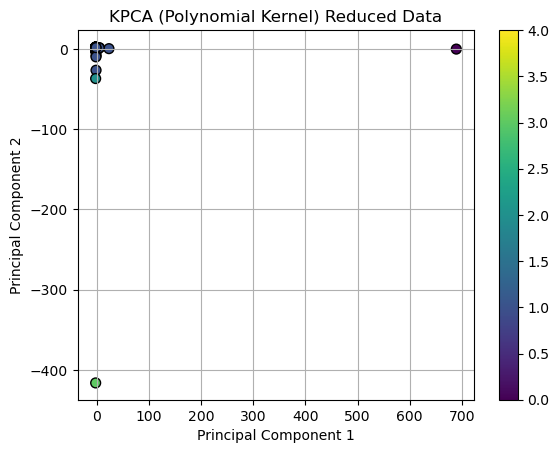

In [65]:
# Scatter plot of PCA reduced data
plt.figure()
plt.scatter(train_data_pca[:, 0], train_data_pca[:, 1], c=train_labels, cmap='viridis', edgecolor='k', s=50)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Reduced Data')
plt.colorbar()
plt.grid()
plt.show()

# Scatter plot of KPCA (Polynomial) reduced data
plt.figure()
plt.scatter(train_data_kpca_poly[:, 0], train_data_kpca_poly[:, 1], c=train_labels, cmap='viridis', edgecolor='k', s=50)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('KPCA (Polynomial Kernel) Reduced Data')
plt.colorbar()
plt.grid()
plt.show()

In [104]:
# Ensure all features are numeric
data = load_and_impute_data(file_path)
features = data.drop(columns=['Label'])

# Convert any non-numeric data to numeric if necessary
features = features.apply(pd.to_numeric, errors='coerce')

# Normalize the features
normalized_features = normalize_data(features)

# Compute the covariance matrix
covariance_matrix = compute_covariance_matrix(normalized_features)

# Identify the top 10 features with the highest covariance values
top_10_features_indices = np.argsort(np.diag(covariance_matrix))[-10:]
top_10_features = features.columns[top_10_features_indices]

print("Top 10 features with the highest covariance values:")
print(top_10_features)

# Extract the top 10 features
top_10_data = data[top_10_features]

# Convert any non-numeric data to numeric if necessary and drop rows with NaN values
top_10_data = top_10_data.apply(pd.to_numeric, errors='coerce')
top_10_data = top_10_data.dropna()  # Drop rows with NaN values

# Ensure the label data is also aligned with the cleaned feature data
labels = data.loc[top_10_data.index, 'Label']

# Convert label data to numeric if necessary
labels = pd.to_numeric(labels, errors='coerce')
labels = labels.dropna()  # Drop rows with NaN values if any

# Ensure the label data is also aligned with the cleaned feature data
top_10_data = top_10_data.loc[labels.index]

# Ensure consistent indices between features and labels
top_10_data = top_10_data.loc[labels.index]

# Split the data
train_data, test_data, train_labels, test_labels = train_test_split(top_10_data, labels, test_size=0.2, random_state=42)

# Normalize the training and test data
train_data_normalized = normalize_data(train_data)
test_data_normalized = normalize_data(test_data)

# Ensure all data passed to the classifier is numeric
train_data_normalized = train_data_normalized.values
test_data_normalized = test_data_normalized.values
train_labels = train_labels.values
test_labels = test_labels.values

# Verify shapes to ensure they match
print("Train data shape:", train_data_normalized.shape)
print("Test data shape:", test_data_normalized.shape)

# Ensure data types are consistent
print(train_data_normalized.dtype)
print(test_data_normalized.dtype)

# Classification using top 10 features
predictions_top_10 = myclassifier(train_data_normalized, train_labels, test_data_normalized)
accuracy_top_10 = calculate_accuracy(test_labels, predictions_top_10)

print(f'Accuracy using top 10 features: {accuracy_top_10}')

# Scatter plot of data using top 10 features (first 2 for visualization)
plt.figure()
plt.scatter(train_data_normalized[:, 0], train_data_normalized[:, 1], c=train_labels, cmap='viridis', edgecolor='k', s=50)
plt.xlabel('Top Feature 1')
plt.ylabel('Top Feature 2')
plt.title('Data using Top 10 Features (First 2 Shown)')
plt.colorbar()
plt.grid()
plt.show()

Top 10 features with the highest covariance values:
Index(['hsa-mir-422a', 'hsa-mir-4464', 'hsa-mir-3186', 'hsa-mir-299',
       'hsa-mir-4321', 'hsa-mir-301a', 'hsa-mir-494', 'hsa-mir-4771-2',
       'hsa-mir-1245a', 'hsa-mir-3606'],
      dtype='object')
Train data shape: (459, 8)
Test data shape: (115, 7)
float64
float64


ValueError: operands could not be broadcast together with shapes (7,) (8,) 